#  Winning a Kaggle Competition in Python - Part 2

> Now that you know the basics of Kaggle competitions, you will learn how to study the specific problem at hand. You will practice EDA and get to establish correct local validation strategies. You will also learn about data leakage.

- toc: true
- branch: master
- badges: true
- comments: true
- author: Hai Nguyen
- categories: [Kaggle, Datacamp, Machine Learning, Python, EDA]
- image: images/winning_kaggle_p2.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

## 2.1 Understand the problem
- Solution workflow 

![sw](images/solution_workflow.png)

- Data type: tabular data, time series, images, text, etc.
- Problem type: classification, regression, ranking, etc.
- Evalation Metrics: ROC AUC, F1-Score, MAE, MSE, etc.
    - Example Custom Metric (Root Mean Squared Error in a Logarithmic scale):
     
    $$ RMSLE = \sqrt{\frac{1}{N}\sum_{i=1}^N (\log(y_i + 1) - \log(\hat{y_i} + 1))^2} $$


- Define a competition metrics

![Define Metric](./images/define_metrics.png)



In [29]:
import numpy as np
import pandas as pd 

# Import log_loss from sklearn
from sklearn.metrics import log_loss

# Define your own LogLoss function
def own_logloss(y_true, prob_pred):
  	# Find loss for each observation
    terms = y_true * np.log(prob_pred) + (1 - y_true) * np.log(1 - prob_pred)
    # Find mean over all observations
    err = np.mean(terms) 
    return -err

y_classification_true = np.array([  1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
                                    1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
                                    0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
                                    1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
                                    0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0])
y_classification_pred = np.array([  0.2082483 , 0.4433677 , 0.71560128, 0.41051979, 0.19100696,
                                    0.96749431, 0.65075037, 0.86545985, 0.02524236, 0.26690581,
                                    0.5020711 , 0.06744864, 0.99303326, 0.2364624 , 0.37429218,
                                    0.21401191, 0.10544587, 0.23247979, 0.30061014, 0.63444227,
                                    0.28123478, 0.36227676, 0.00594284, 0.36571913, 0.53388598,
                                    0.16201584, 0.59743311, 0.29315247, 0.63205049, 0.02619661,
                                    0.88759346, 0.01611863, 0.12695803, 0.77716246, 0.04589523,
                                    0.71099869, 0.97104614, 0.87168293, 0.71016165, 0.95850974,
                                    0.42981334, 0.87287891, 0.35595767, 0.92976365, 0.14877766,
                                    0.94002901, 0.8327162 , 0.84605484, 0.12392301, 0.5964869 ,
                                    0.01639248, 0.72118437, 0.00773751, 0.08482228, 0.22549841,
                                    0.87512453, 0.36357632, 0.53995994, 0.56810321, 0.22546336,
                                    0.57214677, 0.6609518 , 0.29824539, 0.41862686, 0.45308892,
                                    0.93235066, 0.58749375, 0.94825237, 0.55603475, 0.50056142,
                                    0.00353221, 0.48088904, 0.927455  , 0.19836569, 0.05209113,
                                    0.40677889, 0.37239648, 0.85715306, 0.02661112, 0.92014923,
                                    0.680903  , 0.90422599, 0.60752907, 0.81195331, 0.33554387,
                                    0.34956623, 0.38987423, 0.75479708, 0.36929117, 0.24221981,
                                    0.93766836, 0.90801108, 0.34879732, 0.63463807, 0.27384221,
                                    0.20611513, 0.33633953, 0.32709989, 0.8822761 , 0.82230381])

print('Your LogLoss: {:.5f}'.format(own_logloss(y_classification_true, y_classification_pred)))
print('Sklearn LogLoss: {:.5f}'.format(log_loss(y_classification_true, y_classification_pred)))



Your LogLoss: 1.10801
Sklearn LogLoss: 1.10801


## 2.2 Initial EDA 

Goals of EDA:
- Size of the data
- Properties of the target variable
- Properties of the features
- Generate ideas for feature engineering  
<br />


Example - Two sigma connect rental listing inquiries:

- Predict the popularity of an apartment rental listing
- target variable: interest_level
- Problem type: Classification ( 3 classes: 'high', 'medium', 'low' )
- Metric: Multi-class log loss


### 2.2.1 EDA. Part I

In [18]:
import pandas as pd 

twosigma_train = pd.read_json(open("datasets/two_sigma_connect/train.json"))
twosigma_test = pd.read_json(open("datasets/two_sigma_connect/test.json"))

print('Train shape:', twosigma_train.shape)
print('Test shape:', twosigma_test.shape)

Train shape: (49352, 15)
Test shape: (74659, 14)


In [19]:
print(twosigma_train.columns.tolist())
twosigma_train.rename(columns={'listing_id':'id'}, inplace=True)
twosigma_test.rename(columns={'listing_id':'id'}, inplace=True)

TO_KEEP = ['bathrooms', 'bedrooms', 'building_id', 'latitude', 'id', 'longitude', 'manager_id', 'price',  'interest_level']

for col in twosigma_train.columns.tolist():
    if col not in TO_KEEP:
        twosigma_train.drop([col], axis = 1, inplace = True) 
        twosigma_test.drop([col], axis = 1, inplace = True) 

print(twosigma_train.columns.tolist())

['bathrooms', 'bedrooms', 'building_id', 'created', 'description', 'display_address', 'features', 'latitude', 'listing_id', 'longitude', 'manager_id', 'photos', 'price', 'street_address', 'interest_level']
['bathrooms', 'bedrooms', 'building_id', 'latitude', 'id', 'longitude', 'manager_id', 'price', 'interest_level']


In [20]:
print(twosigma_train.interest_level.value_counts())

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64


In [21]:
twosigma_train.set_index('id', inplace = True)
twosigma_test.set_index('id', inplace = True)


twosigma_train.describe()

,bathrooms,bedrooms,latitude,longitude,price
count,49352.00000,49352.000000,49352.000000,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,0.000000,4.490000e+06


In [22]:
twosigma_train.head(10)

,bathrooms,bedrooms,building_id,latitude,longitude,manager_id,price,interest_level
id,,,,,,,,
7170325,1.0,1,8579a0b0d54db803821a35a4a615e97a,40.7108,-73.9539,a10db4590843d78c784171a107bdacb4,2400,medium
7092344,1.0,2,b8e75fc949a6cd8225b455648a951712,40.7513,-73.9722,955db33477af4f40004820b4aed804a0,3800,low
7158677,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,40.7575,-73.9625,c8b10a317b766204f08e613cef4ce7a0,3495,medium
7211212,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,3000,medium
7225292,1.0,0,bfb9405149bfff42a92980b594c28234,40.7439,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,2795,low
7226687,1.0,3,300d27d8ba2adbcbc8c6f2bcbc1c6f9d,40.7348,-73.9865,30a7951cfc21240e8c46b2d079d292e5,7200,low
7126989,2.0,3,0d01cabe55fa5192cdbcabd5c585c1ea,40.7302,-73.9826,9f39caedae295bf81e67463e6fd0af40,6000,low
7114138,1.0,0,d48767c37a934daaf0bbb0e58c755d0c,40.7769,-73.9467,9cbfa7a31ae9dfba70b4383636d99788,1945,high
7131094,0.0,1,d1ca33a2853e64fad6e4009d5d5d168f,40.7346,-73.9811,b89e62bf8cdc98e9fb8b97d9bc627197,2435,low


### 2.2.2 EDA. Part II

Draw some plots

In [23]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# find the median price by the interest level
prices = twosigma_train.groupby('interest_level', as_index=False)['price'].median()

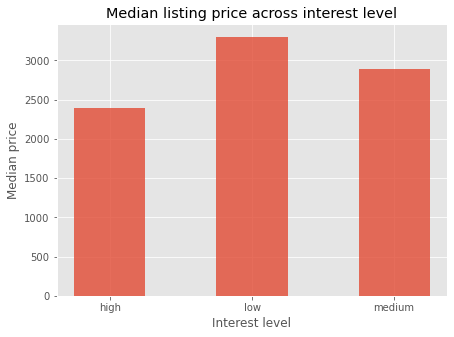

' This shows that lower median price get high interest level, while higher prices get low interest level. '

In [24]:
# Draw a barplot
fig = plt.figure(figsize=(7,5))
plt.bar(prices.interest_level, prices.price, width=0.5, alpha = 0.8)

plt.xlabel('Interest level')
plt.ylabel('Median price')
plt.title('Median listing price across interest level')

plt.show()
""" This shows that lower median price get high interest level, while higher prices get low interest level. """

In [25]:
twosigma_train.interest_level.value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

### 2.2.3 EDA Statistic

As mentioned in the slides, you'll work with New York City taxi fare prediction data. You'll start with finding some basic statistics about the data. Then you'll move forward to plot some dependencies and generate hypotheses on them.

The train and test DataFrames are already available in your workspace.

Instructions:
- Describe the "fare_amount" column to get some statistics about the target variable.
- Find the distribution of the "passenger_count" in the train data (using the value_counts() method).

In [32]:
pd.set_option('display.expand_frame_repr', False)
# Read train data
train = pd.read_csv('datasets/taxi_train_chapter_4.csv')
test = pd.read_csv('datasets/taxi_test_chapter_4.csv')


# Shapes of train and test data
print('Train shape:', train.shape)
print('Test shape:', test.shape)

# Train head()
display(train.head().style.applymap(lambda x:'white-space:nowrap'))

# Describe the target variable
print(train.fare_amount.describe())

# Train distribution of passengers within rides
print(train.passenger_count.value_counts())

Train shape: (20000, 8)
Test shape: (9914, 7)


,id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,4.500000,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,16.900000,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,5.700000,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,7.700000,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,5.300000,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


count    20000.000000
mean        11.303321
std          9.541637
min         -3.000000
25%          6.000000
50%          8.500000
75%         12.500000
max        180.000000
Name: fare_amount, dtype: float64
1    13999
2     2912
5     1327
3      860
4      420
6      407
0       75
Name: passenger_count, dtype: int64


### 2.2.4 EDA plots I
After generating a couple of basic statistics, it's time to come up with and validate some ideas about the data dependencies. Again, the train DataFrame from the taxi competition is already available in your workspace.

To begin with, let's make a scatterplot plotting the relationship between the fare amount and the distance of the ride. Intuitively, the longer the ride, the higher its price.

To get the distance in kilometers between two geo-coordinates, you will use Haversine distance. Its calculation is available with the haversine_distance() function defined for you. The function expects train DataFrame as input.

Instructions: 
- Create a new variable "distance_km" as Haversine distance between pickup and dropoff points.
- Plot a scatterplot with "fare_amount" on the x axis and "distance_km" on the y axis. To draw a scatterplot use matplotlib scatter() method.
- Set a limit on a ride distance to be between 0 and 50 kilometers to avoid plotting outliers.

In [33]:
def haversine_distance(train):
    """ Define Haversine distance """
    data = [train]
    lat1, long1, lat2, long2 = 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'
    
    for i in data:
        R = 6371  #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        
    return d


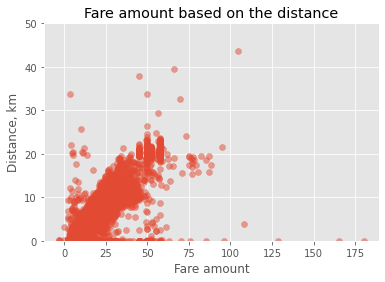

In [28]:
# Calculate the ride distance
train['distance_km'] = haversine_distance(train)

# Draw a scatterplot
plt.scatter(x=train["fare_amount"], y=train["distance_km"], alpha=0.5)
plt.xlabel('Fare amount')
plt.ylabel('Distance, km')
plt.title('Fare amount based on the distance')

# Limit on the distance
plt.ylim(0, 50)
plt.show()

Nice plot! It's obvious now that there is a clear dependency between ride distance and fare amount. So, ride distance is, probably, a good feature. Let's find some others!

## 2.3 Local validation
- K-fold cross-validation
- Stratified K-fold  
 

## 2.4 Validation usage
- Time K-fold
- Overall validation score.  
 